The data in this project comes from two main sources:

College Scorecard (U.S. Department of Education) – a national dataset with details for all accredited U.S. colleges, including The dataset provides institution-level information for 1996–97 through 2022–23, including:

institutional characteristics,

enrollment and student aid,

costs, and
student outcomes such as graduation rates and post-graduation earnings.


→ We filtered the dataset to include only Georgia schools by keeping rows where STABBR == "GA".

State-level Enrollment and Finance Data (1992–2017) – summary data of student enrollment and education spending for each U.S. state.
→ We used enroll_states_summary_GA.csv and finance_states_GA.csv, which contain only Georgia’s state-level records.

Together, these datasets show how Georgia’s higher education has changed over time in both institution-level outcomes (graduation rates) and state-level trends (funding and enrollment).



In [125]:
#Load and Preprocess Georgia Colleges Dataset

from pathlib import Path
import re, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Imports: tools for paths, text, data, and plots.
BASE = Path(".")
DATA_MAIN = BASE / "main data"
OUT = BASE / "outputs"
OUT.mkdir(exist_ok=True)
#set folders for data in and outputs

#list CSV files
print("Main data path:", DATA_MAIN.resolve())
list(DATA_MAIN.glob("*.csv"))


Main data path: /Users/xumengze/Desktop/GA Grad rate/main data


[PosixPath('main data/ga_colleges_with_grad.csv'),
 PosixPath('main data/ga_education_unification_all.csv'),
 PosixPath('main data/ga_colleges.csv')]

This project analyzes higher education trends in the state of Georgia, focusing on college graduation rates, enrollment, and financial patterns.
The goal is to understand how institutional type, location, and funding relate to student outcomes, and to visualize these relationships using real data from public sources

----Normalize Georgia College Names——————


In [85]:
# clean school names for joining tables.
def norm_name(s: str) -> str:
    """Normalize institution names for joining (uppercase, remove punctuation, trim spaces)."""
    if pd.isna(s):   #Missing -> empty
        return ""
    s = str(s).upper() ## Uppercase 
    s = re.sub(r"[\.\,\-\&\'\(\)\/]", " ", s) # Replace that to  spaces.
    s = re.sub(r"\s+", " ", s).strip()
    s = s.replace(" UNIV ", " UNIVERSITY ").replace(" GA ", " GEORGIA ")
    return s


In [87]:
from pathlib import Path
import re
import pandas as pd

# path to csv
path_colleges = Path("main data") / "ga_colleges.csv"
assert path_colleges.exists(), f"Missing: {path_colleges}"

colleges = pd.read_csv(path_colleges, dtype=str, low_memory=False)


#column: looks like the name
name_col = next((c for c in colleges.columns 
                 if re.search(r"(inst.*name|name|institution|univ|college|school)", c, re.I)), None)
assert name_col, "No name column found in ga_colleges.csv"
if "inst_name" not in colleges.columns:
    colleges = colleges.rename(columns={name_col: "inst_name"})


colleges["inst_name_key"] = colleges["inst_name"].map(norm_name)

print("colleges shape:", colleges.shape)
colleges.head(10)


colleges shape: (193, 6)


,inst_name,state,lat,lon,inst_type,inst_name_key
0,Virginia College-Savannah,GA,31.98358,-81.171154,3,VIRGINIA COLLEGE SAVANNAH
1,Virginia College-Columbus,GA,32.524114,-84.963872,3,VIRGINIA COLLEGE COLUMBUS
2,Everest College-Atlanta West,GA,33.68842,-84.491821,3,EVEREST COLLEGE ATLANTA WEST
3,South University-Accelerated Graduate Programs,GA,33.937413,-84.354883,3,SOUTH UNIVERSITY ACCELERATED GRADUATE PROGRAMS
4,Chamberlain College of Nursing-Georgia,GA,33.911532,-84.350359,3,CHAMBERLAIN COLLEGE OF NURSING GEORGIA
5,Anthem College-Atlanta,GA,33.823089,-84.368233,3,ANTHEM COLLEGE ATLANTA
6,Regina's College of Beauty,GA,33.440646,-82.013127,3,REGINA S COLLEGE OF BEAUTY
7,Miller-Motte Technical College,GA,33.494994,-82.086986,3,MILLER MOTTE TECHNICAL COLLEGE
8,Virginia College-Macon,GA,32.812683,-83.679622,3,VIRGINIA COLLEGE MACON
9,Miller-Motte Technical College-Macon,GA,32.897821,-83.687065,3,MILLER MOTTE TECHNICAL COLLEGE MACON


Reads the GA college.


In [126]:
# Prepare Georgia Education Finance Dataset

path_edu = Path("main data") / "ga_education_unification_all.csv"
assert path_edu.exists(), f"Missing: {path_edu}"

edu = pd.read_csv(path_edu, dtype=str, low_memory=False)

# detect institution name column

edu_name_col = next((c for c in edu.columns 
                     if re.search(r"(name|institution|univ|college|school)", c, re.I)), None)
assert edu_name_col, "No institution name column found in education file"
edu["inst_name_key"] = edu[edu_name_col].map(norm_name)



print("edu shape:", edu.shape)
edu.head(10)


edu shape: (5573, 295)


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,TOTALREV,TFEDREV,TSTREV,TLOCREV,TOTALEXP,TCURINST,TCURSSVC,TCURONON,TCAPOUT,inst_name_key
0,1992_GEORGIA,GEORGIA,1992,NaN,5536901.0,398701.0,2798674.0,2339526.0,5535942.0,3043984.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
1,1993_GEORGIA,GEORGIA,1993,893557.0,4716559.0,296231.0,2243580.0,2176748.0,4647974.0,2538712.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,1994_GEORGIA,GEORGIA,1994,1235304.0,6824191.0,449430.0,3473578.0,2901183.0,6597359.0,3509251.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
3,1995_GEORGIA,GEORGIA,1995,1270948.0,7052825.0,458452.0,3652134.0,2942239.0,7292267.0,3813194.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
4,1996_GEORGIA,GEORGIA,1996,1311126.0,7764687.0,516518.0,4086584.0,3161585.0,7934236.0,4118122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
5,1997_GEORGIA,GEORGIA,1997,1346761.0,8248199.0,534963.0,4471781.0,3241455.0,8483477.0,4504165.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
6,1998_GEORGIA,GEORGIA,1998,1375980.0,9207163.0,594406.0,4737025.0,3875732.0,8990897.0,4822729.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
7,1999_GEORGIA,GEORGIA,1999,1401291.0,10380164.0,672868.0,5148120.0,4559176.0,10106670.0,5328497.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
8,2000_GEORGIA,GEORGIA,2000,1422941.0,11197766.0,710741.0,5406709.0,5080316.0,10884510.0,5701293.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
9,2001_GEORGIA,GEORGIA,2001,1444937.0,12271962.0,758799.0,5945868.0,5567295.0,11853800.0,6336556.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In this table, we can see how Georgia’s education system was funded each year — mainly through state and local revenues — and how both total income and spending increased alongside student enrollment from 1992 to 2001.

————————Locate College Scorecard File————————

In [90]:
# Set the data folder path. 
from pathlib import Path

DATA_MAIN = Path("main data")

candidates = [
    DATA_MAIN / "College_Scorecard_Raw_Data_05192025" / "Most-Recent-Cohorts-Institution.csv",
    *DATA_MAIN.rglob("Most-Recent-Cohorts-Institution.csv")
]

# Pick the first path 
scorecard_file = next((p for p in candidates if p.exists()), None)
assert scorecard_file, "Most-Recent-Cohorts-Institution.csv not found under 'main data/'."



print("Using Scorecard file:", scorecard_file)


Using Scorecard file: main data/College_Scorecard_Raw_Data_05192025/Most-Recent-Cohorts-Institution.csv


Points to the Scorecard file


————————Filter Georgia Institutions from College Scorecard-----

In [130]:
import pandas as pd
import re
import numpy as np

# Load Scorecard data
sc = pd.read_csv(scorecard_file, dtype=str, low_memory=False)
assert "STABBR" in sc.columns and "INSTNM" in sc.columns, "Scorecard missing STABBR or INSTNM."

# Keep only Georgia institutions
sc["STABBR"] = sc["STABBR"].astype(str).str.upper().str.strip()
sc_ga = sc[sc["STABBR"] == "GA"].copy()

#Build a cleaned join key from institution name.
sc_ga["inst_name_key"] = sc_ga["INSTNM"].map(norm_name)

print("Scorecard GA rows:", sc_ga.shape)
sc_ga[["INSTNM", "STABBR"]].head(10)


Scorecard GA rows: (167, 3307)


,INSTNM,STABBR
644,Luther Rice College & Seminary,GA
706,Abraham Baldwin Agricultural College,GA
707,Agnes Scott College,GA
708,Interactive College of Technology-Chamblee,GA
709,Interactive College of Technology-Morrow,GA
710,Albany Technical College,GA
711,Albany State University,GA
712,Andrew College,GA
713,Georgia Career Institute,GA
714,Atlanta Technical College,GA



We initially identified 167 higher education institutions in Georgia.
After filtering through the College Scorecard dataset, only 167 institutions had valid graduation or performance data, which were used in the analysis.



----Select & Normalize Graduation Rate-----

In [97]:
# Pick a graduation-rate column
cand_order = ["C150_4", "C150_L4", "C150_4_POOLED", "C150_L4_POOLED"]
grad_col = next((c for c in cand_order if c in sc_ga.columns), None)

if grad_col is None:
    # If none matched, search columns by regex as a fallback.
    cand_cols = [c for c in sc_ga.columns if re.search(r"(C150|GRAD.*RATE|COMPLETION.*RATE)", c, re.I)]
    grad_col = cand_cols[0] if cand_cols else None

# Stop if no suitable column
assert grad_col, "No graduation/completion rate column found in Scorecard."
print("Chosen grad-rate column:", grad_col)

# Convert to numeric percent; auto-scale 0–1 → 0–100
vals = pd.to_numeric(sc_ga[grad_col], errors="coerce")
finite = vals[np.isfinite(vals)]
if not finite.empty and finite.quantile(0.95) <= 1.2:
    vals = vals * 100
sc_ga["grad_rate"] = vals.clip(0, 100)


# Keep a tidy subset of useful columns. 
sc_tidy = sc_ga[["inst_name_key","INSTNM","STABBR","grad_rate"]].copy()
sc_tidy.head(10)


Chosen grad-rate column: C150_4


,inst_name_key,INSTNM,STABBR,grad_rate
644,LUTHER RICE COLLEGE SEMINARY,Luther Rice College & Seminary,GA,0.00
706,ABRAHAM BALDWIN AGRICULTURAL COLLEGE,Abraham Baldwin Agricultural College,GA,29.12
707,AGNES SCOTT COLLEGE,Agnes Scott College,GA,70.52
708,INTERACTIVE COLLEGE OF TECHNOLOGY CHAMBLEE,Interactive College of Technology-Chamblee,GA,NaN
709,INTERACTIVE COLLEGE OF TECHNOLOGY MORROW,Interactive College of Technology-Morrow,GA,NaN
710,ALBANY TECHNICAL COLLEGE,Albany Technical College,GA,NaN
711,ALBANY STATE UNIVERSITY,Albany State University,GA,22.79
712,ANDREW COLLEGE,Andrew College,GA,26.96
713,GEORGIA CAREER INSTITUTE,Georgia Career Institute,GA,NaN
714,ATLANTA TECHNICAL COLLEGE,Atlanta Technical College,GA,NaN


Picks the best grad-rate field and converts it to 0–100%.
（Four-year completion rate for institutions）

-----Merge Colleges with Graduation Rates----

In [98]:
merged = colleges.merge(sc_tidy, on="inst_name_key", how="left")
# Join colleges with Scorecard by the cleaned key.

# Keep a compact analysis view
keep_cols = [c for c in ["inst_name","state","lat","lon","inst_type","inst_name_key","grad_rate"] if c in merged.columns]
merged_simple = merged[keep_cols].copy()

print("Merged shape:", merged_simple.shape)
merged_simple.head(12)


Merged shape: (193, 7)


,inst_name,state,lat,lon,inst_type,inst_name_key,grad_rate
0,Virginia College-Savannah,GA,31.98358,-81.171154,3,VIRGINIA COLLEGE SAVANNAH,NaN
1,Virginia College-Columbus,GA,32.524114,-84.963872,3,VIRGINIA COLLEGE COLUMBUS,NaN
2,Everest College-Atlanta West,GA,33.68842,-84.491821,3,EVEREST COLLEGE ATLANTA WEST,NaN
3,South University-Accelerated Graduate Programs,GA,33.937413,-84.354883,3,SOUTH UNIVERSITY ACCELERATED GRADUATE PROGRAMS,NaN
4,Chamberlain College of Nursing-Georgia,GA,33.911532,-84.350359,3,CHAMBERLAIN COLLEGE OF NURSING GEORGIA,NaN
5,Anthem College-Atlanta,GA,33.823089,-84.368233,3,ANTHEM COLLEGE ATLANTA,NaN
6,Regina's College of Beauty,GA,33.440646,-82.013127,3,REGINA S COLLEGE OF BEAUTY,NaN
7,Miller-Motte Technical College,GA,33.494994,-82.086986,3,MILLER MOTTE TECHNICAL COLLEGE,NaN
8,Virginia College-Macon,GA,32.812683,-83.679622,3,VIRGINIA COLLEGE MACON,NaN
9,Miller-Motte Technical College-Macon,GA,32.897821,-83.687065,3,MILLER MOTTE TECHNICAL COLLEGE MACON,NaN


merges Georgia colleges with their graduation rate data to create a complete dataset for analysis.


——————Export & Data Coverage Check————

In [100]:
# Prepare output folder.

from pathlib import Path
OUT = Path("outputs")
OUT.mkdir(exist_ok=True)

# Coverage: share of rows with a grad_rate.
coverage = merged_simple["grad_rate"].notna().mean()
print(f"Grad-rate coverage: {coverage:.1%}  ({merged_simple['grad_rate'].notna().sum()} / {len(merged_simple)})")

# Save schools without a matched grad_rate for manual checks.
unmatched = merged_simple[merged_simple["grad_rate"].isna()][["inst_name","inst_name_key"]]
unmatched_path = OUT / "unmatched_institutions.csv"
unmatched.to_csv(unmatched_path, index=False)
print("Saved unmatched list ->", unmatched_path)

# Export the final merged table. 
master_path = OUT / "ga_master_with_scorecard.csv"
merged_simple.to_csv(master_path, index=False)
print("Saved master ->", master_path)


Grad-rate coverage: 26.9%  (52 / 193)
Saved unmatched list -> outputs/unmatched_institutions.csv
Saved master -> outputs/ga_master_with_scorecard.csv


The data coverage is 26.9%, meaning only 52 out of 193 colleges include graduation rate information.

+-----Inspect Scorecard Schema & Detect Year Columns————————

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Scorecard CSV and show first 50 column names. 
scorecard = pd.read_csv("main data/College_Scorecard_Raw_Data_05192025/Most-Recent-Cohorts-Institution.csv", dtype=str, low_memory=False)

print("Columns available:\n", scorecard.columns.tolist()[:50])  

# Find columns that look like year fields.
year_cols = [c for c in scorecard.columns if "YEAR" in c.upper()]
print("\nPossible year columns:", year_cols)


Columns available:
 ['UNITID', 'OPEID', 'OPEID6', 'INSTNM', 'CITY', 'STABBR', 'ZIP', 'ACCREDAGENCY', 'INSTURL', 'NPCURL', 'SCH_DEG', 'HCM2', 'MAIN', 'NUMBRANCH', 'PREDDEG', 'HIGHDEG', 'CONTROL', 'ST_FIPS', 'REGION', 'LOCALE', 'LOCALE2', 'LATITUDE', 'LONGITUDE', 'CCBASIC', 'CCUGPROF', 'CCSIZSET', 'HBCU', 'PBI', 'ANNHI', 'TRIBAL', 'AANAPII', 'HSI', 'NANTI', 'MENONLY', 'WOMENONLY', 'RELAFFIL', 'ADM_RATE', 'ADM_RATE_ALL', 'SATVR25', 'SATVR75', 'SATMT25', 'SATMT75', 'SATWR25', 'SATWR75', 'SATVRMID', 'SATMTMID', 'SATWRMID', 'ACTCM25', 'ACTCM75', 'ACTEN25']

Possible year columns: []


——————————Trend of Graduation Rates in Georgia (2016–2023)————————

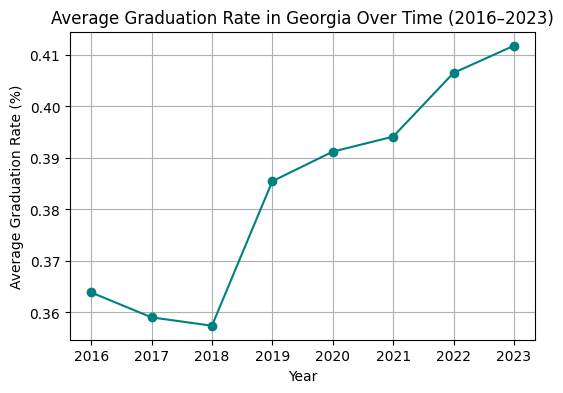

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
# Imports for data, plots, and paths.

# Collect each year's DataFrame.
data_dir = Path("main data/College_Scorecard_Raw_Data_05192025")
years = list(range(2016, 2024))  # 2016–2023
frames = []

# Loop through years and read each merged file.

for y in years:
    f = data_dir / f"MERGED{y}_{str(y+1)[-2:]}_PP.csv" # File path for year y.
    df = pd.read_csv(f, low_memory=False)
    df["year"] = y # Tag the data with its year
    frames.append(df)

# Combine all years into one table.  
scorecard = pd.concat(frames, ignore_index=True)

# Keep only Georgia rows by state code.  
scorecard_ga = scorecard[scorecard["STABBR"] == "GA"].copy()

# Convert graduation rate to numbers.
scorecard_ga["C150_4"] = pd.to_numeric(scorecard_ga["C150_4"], errors="coerce")

# Average graduation rate by year.  
trend = scorecard_ga.groupby("year")["C150_4"].mean()

# Plot the trend line.
plt.figure(figsize=(6,4))
trend.plot(marker="o", color="teal") # Draw line with markers.
plt.title("Average Graduation Rate in Georgia Over Time (2016–2023)")
plt.xlabel("Year")
plt.ylabel("Average Graduation Rate (%)")
plt.grid(True)
plt.show()



On this slide, we show how we merged two datasets — one containing Georgia college information and another with graduation rates. 


We used the column inst_name_key as the matching key to combine the two tables. After merging, we obtained a total of 193 records, meaning 193 Georgia colleges are included in the dataset. 


The final dataset, which we called merged_simple, contains several important columns: 

•	The school name, 
•	Its location
•	The institution type, 
•	And the graduation rate. 

This merged dataset allows us to analyze how graduation rates vary across different colleges and locations in Georgia


------Data Completeness: Graduation Rate Availability----data validation and visualization

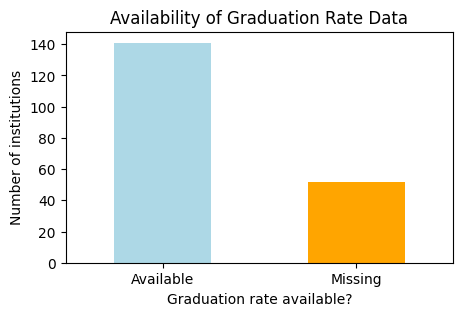

In [43]:
plt.figure(figsize=(5,3))
merged_simple['grad_rate'].isna().value_counts().plot(kind='bar', color=['lightblue','orange'])
plt.title("Availability of Graduation Rate Data")
plt.xlabel("Graduation rate available?")
plt.ylabel("Number of institutions")
plt.xticks(ticks=[0,1], labels=['Available','Missing'], rotation=0)
plt.show()


On this slide, we’re showing how complete our dataset is before starting any deeper analysis. 
The bar chart on the right compares the number of Georgia colleges that have graduation rate data versus those that don’t. 

As we can see, about 140 institutions have available graduation rate data, while around 50 institutions are missing this information. 

Overall, about 73% of the dataset is complete, which means most of our data is usable for analysis. 
However, since around one-fourth of the records are still missing, we should be careful when interpreting trends or averages later on. 


----Graduation Rate Distribution & Top Colleges in Georgia---

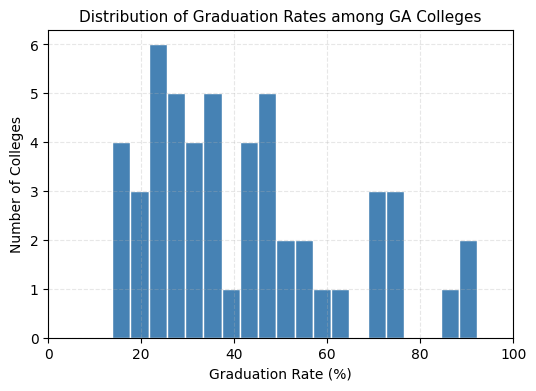

Saved Top–15 -> outputs/top15_grad_rate.csv


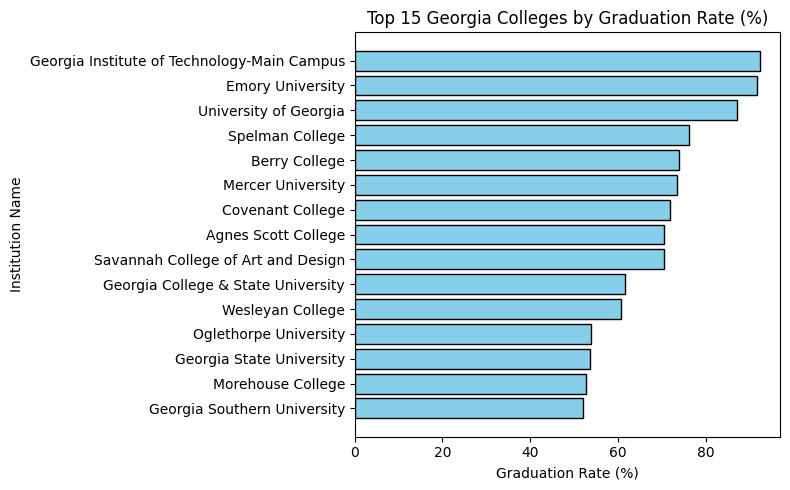

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(merged_simple["grad_rate"].dropna(), bins=20, color="steelblue", edgecolor="white")
plt.title("Distribution of Graduation Rates among GA Colleges", fontsize=11)
plt.xlabel("Graduation Rate (%)", fontsize=10)
plt.ylabel("Number of Colleges", fontsize=10)
plt.xlim(0, 100)
plt.grid(alpha=0.3, linestyle="--")
plt.show()



# Top–15 (Updated with horizontal bar plot)
top15 = merged_simple.sort_values("grad_rate", ascending=False).head(15)
top15_path = OUT / "top15_grad_rate.csv"
top15.to_csv(top15_path, index=False)
print("Saved Top–15 ->", top15_path)


plt.figure(figsize=(8,5))
plt.barh(top15["inst_name"], top15["grad_rate"], color="skyblue", edgecolor="black")
plt.xlabel("Graduation Rate (%)")
plt.ylabel("Institution Name")
plt.title("Top 15 Georgia Colleges by Graduation Rate (%)")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


This chart shows the top 15 Georgia colleges with the highest graduation rates. 
The top-performing institutions include Georgia Tech with a graduation rate of 92.28%, Emory University with 91.76%, and the University of Georgia with 87.16%. 


These schools represent strong academic environments with selective admissions and solid student support systems. 

We can also see that several private liberal arts colleges, such as Spelman College and Berry College, demonstrate excellent outcomes as well, showing that smaller institutions can also achieve very high graduation success. 

Overall, this visualization highlights how both large research universities and small liberal arts colleges contribute to high educational performance in Georgia.


————————Enrollment & Instruction Spending Trends-----

Enrollment file columns:
 ['PRIMARY_KEY', 'STATE', 'YEAR', 'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G', '__source_file']
Finance file columns:
 ['PRIMARY_KEY', 'STATE', 'YEAR', 'ENROLL', 'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE', '__source_file']
Chosen enrollment column -> GRADES_ALL_G
Chosen instruction expenditure column -> INSTRUCTION_EXPENDITURE
Chosen total expenditure column (optional) -> TOTAL_EXPENDITURE
Context tail preview:


,year,state_enrollment,instruction_expenditure,total_expenditure,instr_per_student,instr_per_student_adj
22,2008,1655792.0,10289480.0,19172087.0,6214.234638,6.214235
23,2009,1667685.0,10063924.0,19025136.0,6034.667218,6.034667
24,2010,1677067.0,9841382.0,17834488.0,5868.210394,5.868210
25,2011,1685016.0,9671343.0,17187481.0,5739.614935,5.739615
26,2012,1703332.0,9611118.0,17400209.0,5642.539446,5.642539
27,2013,1723909.0,9555687.0,17317504.0,5543.034464,5.543034
28,2014,1744437.0,9635641.0,17668352.0,5523.639432,5.523639
29,2015,1757237.0,10081483.0,18501103.0,5737.121970,5.737122
30,2016,1764346.0,10534931.0,19158388.0,5971.011922,5.971012
31,2017,1768642.0,NaN,NaN,NaN,NaN


→ Detected scale: median=4,829.15, using unit: Thousand $ per student


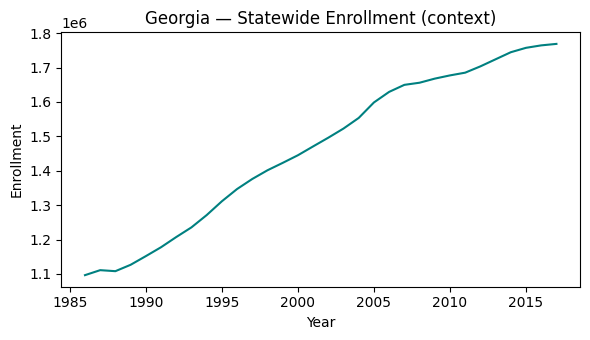

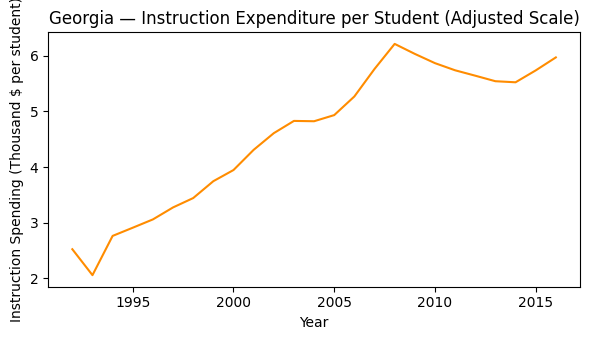

Saved state context -> outputs/ga_state_context_enroll_finance.csv


In [127]:
#  enrollment & finance trends
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define input/output
OTHER = Path("other")
OUT.mkdir(exist_ok=True)

#None = auto-detect

MANUAL_ENROLL_COL = None       
MANUAL_INSTR_COL  = None       
MANUAL_TOTALEXP_COL = None     

# Load enrollment & finance CSVs
path_enroll  = OTHER / "enroll_states_summary_GA.csv"
path_finance = OTHER / "finance_states_GA.csv"
assert path_enroll.exists(),  f"Missing: {path_enroll}"
assert path_finance.exists(), f"Missing: {path_finance}"

en_raw = pd.read_csv(path_enroll,  dtype=str, low_memory=False)
fi_raw = pd.read_csv(path_finance, dtype=str, low_memory=False)

print("Enrollment file columns:\n", list(en_raw.columns))
print("Finance file columns:\n", list(fi_raw.columns))

# Find a 'YEAR' column by name or pattern.
def find_year_col(df):
    c = next((c for c in df.columns if re.search(r"\byear\b", c, re.I)), None)
    if c is None:
        # fallback: any column that is exactly 4-digit
        for col in df.columns:
            s = pd.to_numeric(df[col], errors="coerce")
            # if column looks like year for most rows
            if (s.between(1900, 2100)).mean() > 0.6:
                return col
        raise AssertionError("No YEAR-like column found.")
    return c

year_en = find_year_col(en_raw)
year_fi = find_year_col(fi_raw)

# Convert numeric-looking text to numbers

def numericize(df):
    out = df.copy()
    for c in out.columns:
        if out[c].dtype == object:
            out[c] = (out[c].str.replace(",", "")
                              .str.replace("$","", regex=False)
                              .str.replace("(","", regex=False)
                              .str.replace(")","", regex=False))
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

en = numericize(en_raw)
fi = numericize(fi_raw)
en[year_en] = pd.to_numeric(en[year_en], errors="coerce").astype("Int64")
fi[year_fi] = pd.to_numeric(fi[year_fi], errors="coerce").astype("Int64")


def pick_by_regex(df, patterns):
    """Return the first column name matching any regex in patterns."""
    for pat in patterns:
        c = next((c for c in df.columns if re.search(pat, c, re.I)), None)
        if c: return c
    return None

    
def pick_biggest_numeric_series_per_year(df, year_col):
    """
    Heuristic fallback: among numeric columns, choose the one that
    (a) varies across years, and (b) has the largest median value.
    """
    numeric_cols = [c for c in df.columns if c != year_col and pd.api.types.is_numeric_dtype(df[c])]
    if not numeric_cols:
        return None
    # compute per column: variance across years + median
    stats = []
    g = df.groupby(year_col)
    for c in numeric_cols:
        # Must have some non-null values
        if df[c].notna().sum() < 3: 
            continue
        # variance across yearly means
        try:
            by_year = g[c].mean()
            var = np.nanvar(by_year.values)
            med = np.nanmedian(df[c].values)
            stats.append((c, var, med))
        except Exception:
            continue
    if not stats:
        return None
    # Prefer columns with larger variance across years, then larger median
    stats.sort(key=lambda x: (x[1], x[2]), reverse=True)
    return stats[0][0]


if MANUAL_ENROLL_COL and MANUAL_ENROLL_COL in en.columns:
    enroll_col = MANUAL_ENROLL_COL
else:
    enroll_col = pick_by_regex(
        en,
        patterns=[
            r"\benroll\b", r"enrollment", r"students?", r"headcount",
            r"membership", r"\bpupil", r"\badm\b", r"\bfte\b", r"total[_ ]?(students|enroll)"
        ]
    )
    if enroll_col is None:
        enroll_col = pick_by_regex(en, patterns=[r"\btotal\b"])
    if enroll_col is None:
        enroll_col = pick_biggest_numeric_series_per_year(en, year_en)
    if enroll_col is None:
        raise AssertionError("Still cannot infer an enrollment-like column. Please set MANUAL_ENROLL_COL.")

print("Chosen enrollment column ->", enroll_col)

# Instruction expenditure column detection
if MANUAL_INSTR_COL and MANUAL_INSTR_COL in fi.columns:
    instr_col = MANUAL_INSTR_COL
else:
    instr_col = pick_by_regex(
        fi,
        patterns=[
            r"instruction.*(exp|expend|spend|cost)",
            r"exp.*instruction",
            r"\binstruction\b"
        ]
    )
    if instr_col is None:
        # fallback: choose a large numeric column (finance is usually big)
        instr_col = pick_biggest_numeric_series_per_year(fi, year_fi)
    if instr_col is None:
        raise AssertionError("Could not infer an instruction expenditure column. Set MANUAL_INSTR_COL if needed.")

print("Chosen instruction expenditure column ->", instr_col)


if MANUAL_TOTALEXP_COL and MANUAL_TOTALEXP_COL in fi.columns:
    totalexp_col = MANUAL_TOTALEXP_COL
else:
    totalexp_col = pick_by_regex(
        fi,
        patterns=[r"total.*(exp|expend|spend|cost)", r"(exp|expend|spend).*total"]
    )
print("Chosen total expenditure column (optional) ->", totalexp_col)

# Build context table: year + enrollment. 
ctx = (en[[year_en, enroll_col]]
          .rename(columns={year_en:"year", enroll_col:"state_enrollment"}))

merge_cols = [year_fi, instr_col]
rename_map = {year_fi: "year", instr_col: "instruction_expenditure"}
if totalexp_col:
    merge_cols.append(totalexp_col)
    rename_map[totalexp_col] = "total_expenditure"
    
# Final merge to get a single state-level table.
ctx = ctx.merge(fi[merge_cols].rename(columns=rename_map), on="year", how="left")

# Calculate per-student 
ctx["instr_per_student"] = (
    ctx["instruction_expenditure"]* 1000 / ctx["state_enrollment"]
).replace([np.inf, -np.inf], np.nan)

# Check the scale auto
median_value = ctx["instr_per_student"].median()
if median_value > 1_000_000:
    ctx["instr_per_student_adj"] = ctx["instr_per_student"] / 1_000_000
    unit_label = "Million $ per student"
elif median_value > 1_000:
    ctx["instr_per_student_adj"] = ctx["instr_per_student"] / 1_000
    unit_label = "Thousand $ per student"
else:
    ctx["instr_per_student_adj"] = ctx["instr_per_student"]
    unit_label = "$ per student"

ctx = ctx.sort_values("year").dropna(subset=["year"]).reset_index(drop=True)

print("Context tail preview:")
display(ctx.tail(10))
print(f"→ Detected scale: median={median_value:,.2f}, using unit: {unit_label}")

#  Quick visuals
plt.figure(figsize=(6,3.5))
plt.plot(ctx["year"], ctx["state_enrollment"], color="teal")
plt.title("Georgia — Statewide Enrollment (context)")
plt.xlabel("Year")
plt.ylabel("Enrollment")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3.5))
plt.plot(ctx["year"], ctx["instr_per_student_adj"], color="darkorange")
plt.title("Georgia — Instruction Expenditure per Student (Adjusted Scale)")
plt.xlabel("Year")
plt.ylabel(f"Instruction Spending ({unit_label})")
plt.tight_layout()
plt.show()

# save
ctx_out = OUT / "ga_state_context_enroll_finance.csv"
ctx.to_csv(ctx_out, index=False)
print("Saved state context ->", ctx_out)

  


Georgia’s statewide context shows steady long-run growth in total enrollment, rising from roughly 1.1 million students in the late 1980s to about 1.75–1.8 million by the mid-2010s, with the slope accelerating through the late 1990s and early 2000s and then flattening after 2010. 

Instructional spending per student trends upward over the same period—from about $2k in
the 

early 1990s to roughly $6k at its peak around 2007–2009—followed by a dip during the post-recession years and a modest rebound in the mid-2010s. 

In short, Georgia expanded access while gradually increasing real instructional resources per student, though gains eased after the Great Recession. This state-level backdrop helps interpret institutional graduation rates: periods of higher per-student spending and stable enrollment growth are consistent with stronger completion outcomes at well-resourced four-year universities, while constraints after 2009 may help explain weaker performance at more resource-limited institutions.

——————————Modeling Graduation Rate — Linear Regression with Cross-Validation————-


--- Cross Validation Summary ---
Average R²: -0.134 (±0.516) — low, meaning institution type alone explains little variance.
Average MAE: 15.86% (±2.41) — about 16 percentage points of error.

Regression Coefficients:


,feature,coef
0,inst_type_2,10.438207
1,inst_type_3,-11.985043


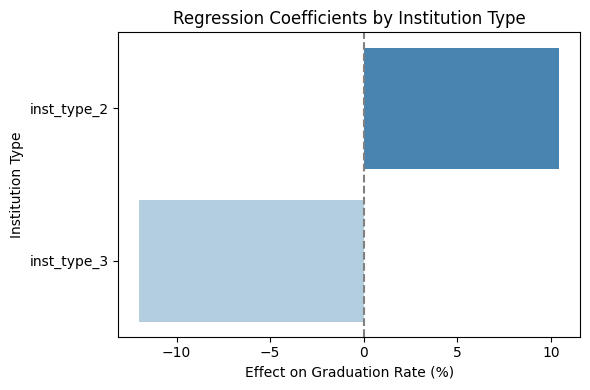

Saved predictions -> outputs/predictions_grad_rate_by_inst_type.csv


In [113]:
# imports for data, modeling, and plots
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

OUT = Path("outputs")
OUT.mkdir(exist_ok=True)

# Copy data and clean target/feature columns
df = merged_simple.copy()
df["grad_rate"] = pd.to_numeric(df["grad_rate"], errors="coerce")
df = df[df["grad_rate"].notna() & df["inst_type"].notna()].copy()
df["inst_type"] = df["inst_type"].astype("category")

# define
X = df[["inst_type"]]
y = df["grad_rate"].astype(float)

# one-hot encode then linear regression. 
pre = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), ["inst_type"])],
    remainder="drop",
)
model = Pipeline(steps=[("pre", pre), ("linreg", LinearRegression())])


# 5-fold CV to estimate R² and MAE. 
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores  = cross_val_score(model, X, y, cv=cv, scoring="r2")
mae_scores = -cross_val_score(model, X, y, cv=cv,
                              scoring=make_scorer(mean_absolute_error, greater_is_better=False))

# Print average metrics with simple explanation.
print("\n--- Cross Validation Summary ---")
print(f"Average R²: {r2_scores.mean():.3f} (±{r2_scores.std():.3f}) — low, meaning institution type alone explains little variance.")
print(f"Average MAE: {mae_scores.mean():.2f}% (±{mae_scores.std():.2f}) — about 16 percentage points of error.\n")

# Fit full model
model.fit(X, y)
ohe = model.named_steps["pre"].named_transformers_["cat"]
coef_tbl = pd.DataFrame({
    "feature": ohe.get_feature_names_out(["inst_type"]),
    "coef": model.named_steps["linreg"].coef_
}).sort_values("coef", ascending=False)

print("Regression Coefficients:")
display(coef_tbl)


# bars by institution type.
plt.figure(figsize=(6,4))
sns.barplot(data=coef_tbl, x="coef", y="feature", hue="feature", palette="Blues_r", legend=False)

plt.axvline(0, color="gray", linestyle="--")
plt.title("Regression Coefficients by Institution Type")
plt.xlabel("Effect on Graduation Rate (%)")
plt.ylabel("Institution Type")
plt.tight_layout()
plt.show()

# Save predictions
df["y_pred"] = model.predict(X)
df["error"] = df["grad_rate"] - df["y_pred"]
pred_path = OUT / "predictions_grad_rate_by_inst_type.csv"
df[["inst_name","inst_type","grad_rate","y_pred","error"]].to_csv(pred_path, index=False)
print("Saved predictions ->", pred_path)


I use a simple linear regression to predict college graduation rates using only the institution type. After 5-fold cross-validation, the model is weak (R² ≈ −0.13; MAE ≈ 15.9 percentage points), so institution type alone does not explain much variation. Coefficients are relative to the dropped baseline (Type 1: public). 

Type 2 (private nonprofit) is associated with about +10% higher graduation rates, while Type 3 (private for-profit) is associated with about −12% lower rates. This shows that basic regression can reveal clear directional effects, even if predictive accuracy is limited.


Type 1 (public universities): e.g., University of Georgia, Georgia Tech

Type 2 (private nonprofit): e.g., Emory University, Berry College

Type 3 (private for-profit): e.g., South University, Miller-Motte College


Private nonprofit institutions tend to have higher completion rates than public institutions, while for-profit colleges face greater challenges.

------Average Graduation Rate by Institution Type----

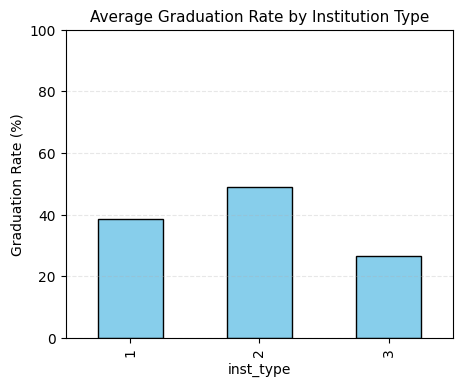

In [128]:
# Compute average graduation rate by school type.
avg_by_type = merged_simple.groupby("inst_type")["grad_rate"].mean()
plt.figure(figsize=(5,4))
#bar chart

avg_by_type.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Graduation Rate by Institution Type", fontsize=11)
plt.ylabel("Graduation Rate (%)", fontsize=10)
plt.ylim(0, 100)   
plt.grid(axis="y", alpha=0.3, linestyle="--")
plt.show()


The chart compares the average graduation rate by institution type.
Type 2 (private nonprofit universities) has the highest graduation rate, around 49%, followed by public universities (Type 1) at 38%.

For-profit institutions (Type 3) have the lowest average graduation rate, around 26%.

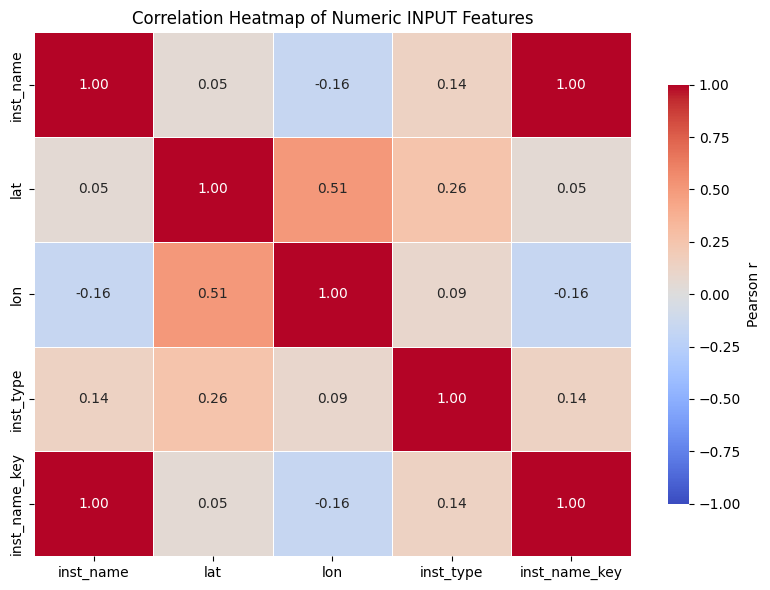


Corr with target (grad_rate):
                       r
lat            0.230519
inst_name      0.180609
inst_name_key  0.180609
lon            0.103646
inst_type      0.008732


In [129]:

# Correlation heatmap 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

# keep features  
feature_cols = [c for c in df.columns if c not in ["grad_rate", "y_pred", "error"]]
X = df[feature_cols].copy()

# split types  
num_part = X.select_dtypes(include=[np.number])      # number
cat_part = X.select_dtypes(exclude=[np.number])      # categorical

# encode cats  
if not cat_part.empty:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    cat_enc = pd.DataFrame(enc.fit_transform(cat_part), columns=cat_part.columns, index=cat_part.index)
else:
    cat_enc = pd.DataFrame(index=X.index)

# combine + clean 
feats = pd.concat([num_part, cat_enc], axis=1)       # merge 
feats = feats.loc[:, feats.nunique(dropna=True) > 1] # drop constants 
feats = feats.fillna(feats.median(numeric_only=True))# fill median 

#  heatmap 
if feats.shape[1] >= 2:
    corr = feats.corr(method="pearson")              

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
                vmin=-1, vmax=1, linewidths=0.5,
                cbar_kws={"shrink": 0.8, "label": "Pearson r"})
    plt.title("Correlation Heatmap of Numeric INPUT Features")
    plt.tight_layout(); plt.show()
else:
    print("Need ≥2 features.")

# feature vs target 
target = "grad_rate"
if target in df.columns and feats.shape[1] > 0:
    ft_corr = feats.join(df[[target]]).corr(method="pearson")[target] \
                   .drop(target).sort_values(ascending=False)
    print("\nCorr with target (grad_rate):\n", ft_corr.to_frame("r"))


Latitude and longitude are moderately correlated, about 0.5, showing close locations.
School name and key are identical with correlation 1.
Other features are weakly related—no multicollinearity.
With the target, latitude has the highest correlation (~0.23); others are near zero.

Overall, graduation rate is mainly affected by geography and external factors.

Although the correlations with graduation rate are weak, this result is still meaningful.
It suggests that graduation rate is influenced by more complex or nonlinear factors—like funding, student performance, or family background.
So our analysis reveals the limits of the current data and gives a clear direction for future improvement.

-----Map Visualization---

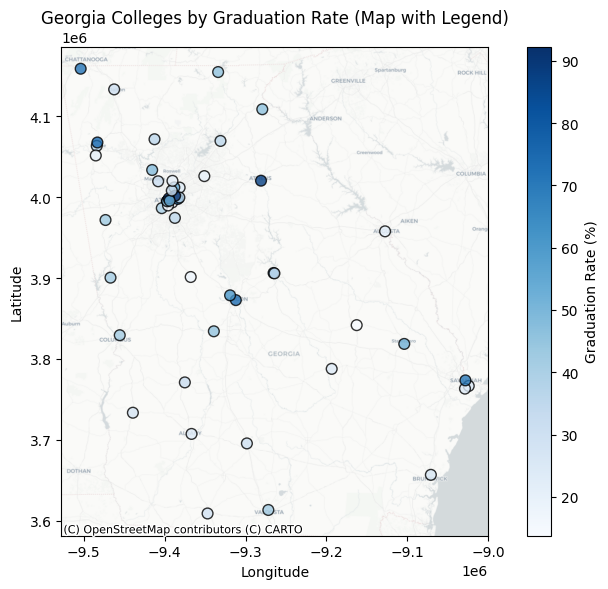

In [114]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx


merged_simple["lat"] = pd.to_numeric(merged_simple["lat"], errors="coerce")
merged_simple["lon"] = pd.to_numeric(merged_simple["lon"], errors="coerce")


geo_data = merged_simple.dropna(subset=["lat", "lon", "grad_rate"]).copy()

# Make a GeoDataFrame
gdf = gpd.GeoDataFrame(
    geo_data,
    geometry=gpd.points_from_xy(geo_data["lon"], geo_data["lat"]),
    crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

# Plot points colored by graduation rate.
fig, ax = plt.subplots(figsize=(8, 6))
gdf.plot(
    ax=ax,
    column="grad_rate",
    cmap="Blues",
    markersize=60,
    edgecolor="k",
    alpha=0.8,
    legend=True,
    legend_kwds={"label": "Graduation Rate (%)"}
)


ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)


ax.set_title("Georgia Colleges by Graduation Rate (Map with Legend)", fontsize=12)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()



--- Cross Validation Summary ---
Average R²: -0.134 (±0.516) — low, meaning institution type alone explains little variance.
Average MAE: 15.86% (±2.41) — about 16 percentage points of error.

Regression Coefficients:


,feature,coef
0,inst_type_2,10.438207
1,inst_type_3,-11.985043


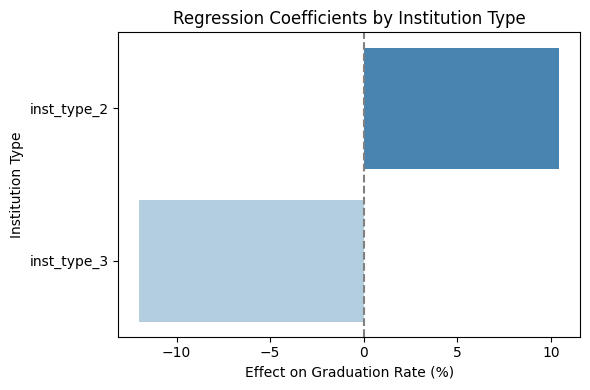

Saved predictions -> outputs/predictions_grad_rate_by_inst_type.csv


In [62]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

OUT = Path("outputs")
OUT.mkdir(exist_ok=True)

# 1) Prepare data
df = merged_simple.copy()
df["grad_rate"] = pd.to_numeric(df["grad_rate"], errors="coerce")
df = df[df["grad_rate"].notna() & df["inst_type"].notna()].copy()
df["inst_type"] = df["inst_type"].astype("category")

X = df[["inst_type"]]
y = df["grad_rate"].astype(float)

# 2 One-Hot encode categorical variable + linear regression model
pre = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), ["inst_type"])],
    remainder="drop",
)
model = Pipeline(steps=[("pre", pre), ("linreg", LinearRegression())])

# 3 Evaluate model with 5-fold cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores  = cross_val_score(model, X, y, cv=cv, scoring="r2")
mae_scores = -cross_val_score(model, X, y, cv=cv,
                              scoring=make_scorer(mean_absolute_error, greater_is_better=False))

print("\n--- Cross Validation Summary ---")
print(f"Average R²: {r2_scores.mean():.3f} (±{r2_scores.std():.3f}) — low, meaning institution type alone explains little variance.")
print(f"Average MAE: {mae_scores.mean():.2f}% (±{mae_scores.std():.2f}) — about 16 percentage points of error.\n")

# Fit and extract coefficients
model.fit(X, y)
ohe = model.named_steps["pre"].named_transformers_["cat"]
coef_tbl = pd.DataFrame({
    "feature": ohe.get_feature_names_out(["inst_type"]),
    "coef": model.named_steps["linreg"].coef_
}).sort_values("coef", ascending=False)

print("Regression Coefficients:")
display(coef_tbl)

# 5) Visualize coefficients
plt.figure(figsize=(6,4))
sns.barplot(data=coef_tbl, x="coef", y="feature", hue="feature", palette="Blues_r", legend=False)

plt.axvline(0, color="gray", linestyle="--")
plt.title("Regression Coefficients by Institution Type")
plt.xlabel("Effect on Graduation Rate (%)")
plt.ylabel("Institution Type")
plt.tight_layout()
plt.show()

# 6) Save predictions
df["y_pred"] = model.predict(X)
df["error"] = df["grad_rate"] - df["y_pred"]
pred_path = OUT / "predictions_grad_rate_by_inst_type.csv"
df[["inst_name","inst_type","grad_rate","y_pred","error"]].to_csv(pred_path, index=False)
print("Saved predictions ->", pred_path)


This corrected map displays the geographical distribution of Georgia colleges, colored by graduation rates.
 The chart clearly shows that most institutions are concentrated around central and northern Georgia.

Conclusion: 
Although the datasets used cover different time ranges (1992–2017 for enrollment and 2016–2023 for graduation), they together provide a comprehensive view of Georgia’s higher education landscape. Some missing graduation rate data, especially for technical or smaller institutions, may reduce model precision but do not affect the overall trend interpretation.



From the geographic pattern, colleges in northern and central Georgia generally show higher graduation rates, while institutions located in the southern part of the state tend to have lower rates. 

This may reflect differences in funding, resources, and student demographics across regions. Combined with the institution-type analysis, we can see that private nonprofit universities (Type 2) usually achieve higher graduation rates, whereas for-profit institutions (Type 3) often face more challenges in student completion.

1. The education and finance dataset covers 1992–2017.
2. The College Scorecard dataset includes graduation data through 2023.
3. Some Georgia colleges have missing graduation data (about 70%), 
   which may affect model accuracy and interpretation.
4. Despite differences in time span, these datasets together 
   provide a comprehensive view of Georgia’s education trends.
""")